# Facial Keypoint Detection


## Initialize Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
from tensorflow.keras.layers import LeakyReLU, ReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Convolution2D, BatchNormalization, Flatten
from tensorflow.keras.layers import Dense, Dropout, Input, MaxPool2D
from tensorflow.keras.optimizers import Nadam
from keras import backend
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import cv2
import os, gc, json, math

Using TensorFlow backend.
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflo

In [2]:
import keras
print(keras.__version__)
import tensorflow
print(tensorflow.__version__)

2.2.4
1.13.1


## Functions

In [3]:
def convert_pixels(data):
    """
    Convert pixels to the right intensity 0-1 and in a square matrix.
    """
    data = np.array([row.split(' ') for row in data['Image']],dtype='float') / 255.0
    data = data.reshape(-1,96,96,1)
    return(data)

In [4]:
def view_img(sample_img,coord=None):
    """
    Display an image. For debugging, display a coordinate on the image.
    input:
        - sample_img: numpy array. image to be displayed
        - coord: lst. of coordinates in form [[x_coordinate,y_coordinate],[x_coordinate,y_coordinate]]
    TODO handle multiple coordinates. Work out bugs with multiple coordinates
    """
    plt.figure()
    plt.imshow(sample_img.reshape(96,96),cmap='gray')
    if coord is not None:
        plt.scatter(coord[0],coord[1],marker = '*',c='r')
    plt.show()

In [5]:
def get_facial_keypoints(data,ind):
    """
    Structure the coordinates for all facial keypoints for a single image.
    inputs:
        - data: numpy array containing rows as each image sample and columns as facial keypoint coordinates
        - ind: index of the image
    output:
        - numpy array with format [[list of x-coordinates],[list of y-coordinates]]
    """
    data[ind]
    it = iter(data[ind])
    x_coord = []
    y_coord = []

    for x in it:
        x_coord.append(x)
        y_coord.append(next(it))
    
    return(np.array([x_coord,y_coord]))


## Import Data

In [6]:
# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del model # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))
    
reset_keras()    

20


In [8]:
if not os.path.exists('../output/'):
    os.makedirs('../output/model')
    os.makedirs('../output/history')
    
    
model_dir = "../output/model/"
history_dir = "../output/history/"

train_file = '../input/training/training.csv'
test_file = '../input/test/test.csv'
train_data = pd.read_csv(train_file)  
#test_data = pd.read_csv(test_file)


bad_samples = [1747, 1877, 1881, 1979, 2154, 2199, 2289, 2321, 2453, 3173, 3296, 3447, 4180, 6859,
              2090, 2175, 1907, 2562, 2818, 3296, 3447, 4263, 4482, 4490, 4636, 5059, 6493, 6906]

#train_data = train_data.drop(bad_samples).reset_index(drop=True)

## Exploratory Data Analysis

In [ ]:
train_data.head().T

Create training vector with images and normalize thee

In [9]:
x_train = convert_pixels(train_data)

Generate labels 

In [10]:
y_train = train_data[[col for col in train_data.columns if col != 'Image']].to_numpy()
imputer = KNNImputer(n_neighbors=3, weights='distance')

#imputer = IterativeImputer(max_iter=1000, tol=0.01)
y_train = imputer.fit_transform(y_train)

## Feature Engineering

### Set feature engineering parameters

In [11]:
fill_na = False
add_flip_horiz = False
add_blur_img = False
add_rotate_img = False
orig_x_train = x_train.copy()
orig_y_train = y_train.copy()
y_train = imputer.fit_transform(y_train)

### Fill NA in the training labels.

In [12]:
if fill_na:
    # https://stackoverflow.com/questions/18689235/numpy-array-replace-nan-values-with-average-of-columns
    # get column means
    col_mean = np.nanmean(y_train,axis=0)

    # find the x,y indices that are missing from y_train
    inds = np.where(np.isnan(y_train))

    # fill in missing values in y_train with the column means. "take" is much more efficient than fancy indexing
    y_train[inds] = np.take(col_mean, inds[1])


### Flip images horizontally and add to the training data

In [13]:
def flip_img_horiz():
    """
    Flip images horizontally for all training images
    """
    # Flip images
    flip_img = np.array([np.fliplr(orig_x_train[[ind]][0]) for ind in range(orig_x_train.shape[0])])
    
    # Flip coordinates
    train_data_flip = train_data.copy()
    x_columns = [col for col in train_data.columns if '_x' in col]
    train_data_flip[x_columns] = train_data[x_columns].applymap(lambda x: 96-x)
    
    #left and right are swapped so undo
    left_columns = [col for col in train_data.columns if 'left' in col]
    right_columns = [col for col in train_data.columns if 'right' in col]
    train_data_flip[left_columns+right_columns] = train_data_flip[right_columns+left_columns]
    
    flip_coord = train_data_flip[[col for col in train_data if col != 'Image']].to_numpy()
    return(flip_img,flip_coord)

if add_flip_horiz:
    # Apply the augmentation and add the new data to the training set
    flipped_img,flipped_coord = flip_img_horiz()
    flipped_coord = imputer.fit_transform(flipped_coord)
    #x_train = np.append(x_train,flipped_img,axis=0)
    #y_train = np.append(y_train,flipped_coord,axis=0)
    
    

### Add Gaussian blurring with a 5x5 filter with $\sigma$ = 2.

In [14]:
def blur_img():
    """
    Add Gaussian blurring to the images
    """
    # https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html
    blur_img = np.array([cv2.GaussianBlur(orig_x_train[[ind]][0],(5,5),2).reshape(96,96,1) for ind in range(orig_x_train.shape[0])])
    
    return(blur_img)

if add_blur_img:
    x_train = np.append(x_train,blur_img(),axis=0)
    y_train = np.append(y_train,orig_y_train,axis=0)

In [15]:
def rotate_img(x_train, y_train):
    """"
    Rotate images by angles between [5, 10, 15 degrees]
    """
    angles = [7, -7, 10, -10, 15, -15]
    b = np.ones((1,3))
    rows,cols = (96,96)
    x_train_rot = []
    y_train_rot = y_train.copy()
    M_angles = [cv2.getRotationMatrix2D((cols/2,rows/2),angle,1) for angle in angles]
    
    for i in range(x_train.shape[0]):
        #M = cv2.getRotationMatrix2D((cols/2,rows/2),np.random.choice(angles,1),1)
        M = M_angles[np.random.choice(len(M_angles))]
        x_train_rot.append((cv2.warpAffine(x_train[[i]].reshape(rows,cols,1),M,(cols,rows)).reshape(96,96,1)))
       
        #apply affine transformation to (x,y) labels
        for j in range(int(y_train.shape[1]/2)):
            b[:,0:2] = y_train[i,2*j:2*j+2]
            y_train_rot[i,2*j:2*j+2] = np.dot(b,M.transpose()) 
    
    x_train_rot = np.array(x_train_rot)
    return x_train_rot, y_train_rot

if add_rotate_img:
    if add_flip_horiz:
        x_rotate, y_rotate = rotate_img(flipped_img,flipped_coord) #x_train,y_train)
    else:
        x_rotate, y_rotate = rotate_img(x_train,y_train)
    x_train = np.append(x_train,x_rotate,axis=0)
    y_train = np.append(y_train,y_rotate,axis=0)   
    
else:
    if add_flip_horiz:
          x_train = np.append(x_train,flipped_image,axis=0)
          y_train = np.append(y_train,flipped_coord,axis=0)

## Modeling

In [16]:
# Define callback function if detailed log required
class History(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.train_loss = []
        self.train_rmse = []
        self.val_rmse = []
        self.val_loss = []

    def on_batch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.train_rmse.append(logs.get('rmse'))
        
    def on_epoch_end(self, batch, logs={}):    
        self.val_rmse.append(logs.get('val_rmse'))
        self.val_loss.append(logs.get('val_loss'))
        
# Implement ModelCheckPoint callback function to save CNN model
class CNN_ModelCheckpoint(tensorflow.keras.callbacks.Callback):

    def __init__(self, model, filename):
        self.filename = filename
        self.cnn_model = model

    def on_train_begin(self, logs={}):
        self.max_val_rmse = math.inf
        
 
    def on_epoch_end(self, batch, logs={}):    
        val_rmse = logs.get('val_rmse')
        if(val_rmse < self.max_val_rmse):
           self.max_val_rmse = val_rmse
           self.cnn_model.save_weights(self.filename)


In [17]:
def base_model():
    model_input = Input(shape=(96,96,1))

    x = Convolution2D(32, (3,3), padding='same', use_bias=False)(model_input)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Convolution2D(64, (3,3), padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Convolution2D(96, (3,3), padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Convolution2D(128, (3,3),padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Convolution2D(256, (3,3),padding='same',use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Convolution2D(512, (3,3), padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(512,activation='relu')(x)
    x = Dropout(0.1)(x)
    model_output = Dense(30)(x)
    model = Model(model_input, model_output, name="base_model")
    return model

model = base_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)    

In [18]:
# Custom RMSE metric
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

#from tensorflow.keras.optimizers.schedules import InverseTimeDecay

# Use Nadam optimizer with variable learning rate
optimizer = Nadam(lr=0.00001,
                  beta_1=0.9,
                  beta_2=0.999,
                  epsilon=1e-08,
                  schedule_decay=0.004)


# Loss: MSE and Metric = RMSE
model.compile(optimizer= optimizer, 
              loss='mean_squared_error',
              metrics=[rmse])

#Callback to save the best model
saveBase_Model = CNN_ModelCheckpoint(model, model_dir+"base_model_weights_1.h5")

#define callback functions
callbacks = [#EarlyStopping(monitor='val_rmse', patience=3, verbose=2),
             saveBase_Model]

Instructions for updating:
Use tf.cast instead.


Run for 1000 epochs and keeping 20% train-valid split

Train on 5639 samples, validate on 1410 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
5639/5639 [==============================] - 8s 1ms/sample - loss: 2573.6141 - rmse: 50.6997 - val_loss: 2676.4422 - val_rmse: 51.7079
Epoch 2/500
5639/5639 [==============================] - 4s 641us/sample - loss: 2356.3563 - rmse: 48.5006 - val_loss: 2673.7063 - val_rmse: 51.6815
Epoch 3/500
5639/5639 [==============================] - 4s 644us/sample - loss: 2071.5292 - rmse: 45.4438 - val_loss: 2671.9345 - val_rmse: 51.6643
Epoch 4/500
5639/5639 [==============================] - 4s 654us/sample - loss: 1734.9676 - rmse: 41.5427 - val_loss: 2666.3240 - val_rmse: 51.6100
Epoch 5/500
5639/5639 [==============================] - 4s 660us/sample - loss: 1395.8675 - rmse: 37.2092 - val_loss: 2646.2285 - val_rmse: 51.4149
Epoch 6/500
5639/5639 [==============================] - 4s 658us/sample - loss: 1092.1217 - rmse: 32.8539 - val_loss: 2596.8966 - val_rmse: 50.9329
Epoch 7/500


5639/5639 [==============================] - 3s 609us/sample - loss: 34.4056 - rmse: 5.7032 - val_loss: 12.9606 - val_rmse: 3.2095
Epoch 56/500
5639/5639 [==============================] - 3s 608us/sample - loss: 34.1813 - rmse: 5.6772 - val_loss: 12.7667 - val_rmse: 3.1821
Epoch 57/500
5639/5639 [==============================] - 3s 597us/sample - loss: 34.3550 - rmse: 5.6943 - val_loss: 13.9688 - val_rmse: 3.3469
Epoch 58/500
5639/5639 [==============================] - 3s 606us/sample - loss: 33.7362 - rmse: 5.6399 - val_loss: 12.5619 - val_rmse: 3.1551
Epoch 59/500
5639/5639 [==============================] - 3s 599us/sample - loss: 33.6245 - rmse: 5.6364 - val_loss: 13.6610 - val_rmse: 3.3048
Epoch 60/500
5639/5639 [==============================] - 3s 595us/sample - loss: 33.5989 - rmse: 5.6300 - val_loss: 14.0694 - val_rmse: 3.3553
Epoch 61/500
5639/5639 [==============================] - 3s 612us/sample - loss: 33.6196 - rmse: 5.6315 - val_loss: 12.4969 - val_rmse: 3.1473
Epoch

Epoch 112/500
5639/5639 [==============================] - 3s 596us/sample - loss: 26.5224 - rmse: 4.9996 - val_loss: 10.4250 - val_rmse: 2.8499
Epoch 113/500
5639/5639 [==============================] - 3s 586us/sample - loss: 26.2834 - rmse: 4.9801 - val_loss: 14.6885 - val_rmse: 3.4630
Epoch 114/500
5639/5639 [==============================] - 3s 599us/sample - loss: 25.9838 - rmse: 4.9514 - val_loss: 10.2930 - val_rmse: 2.8330
Epoch 115/500
5639/5639 [==============================] - 3s 586us/sample - loss: 25.9196 - rmse: 4.9450 - val_loss: 10.9937 - val_rmse: 2.9483
Epoch 116/500
5639/5639 [==============================] - 3s 583us/sample - loss: 25.8699 - rmse: 4.9388 - val_loss: 11.1047 - val_rmse: 2.9638
Epoch 117/500
5639/5639 [==============================] - 3s 583us/sample - loss: 25.8484 - rmse: 4.9369 - val_loss: 10.3352 - val_rmse: 2.8407
Epoch 118/500
5639/5639 [==============================] - 3s 589us/sample - loss: 25.6843 - rmse: 4.9244 - val_loss: 11.6413 - va

5639/5639 [==============================] - 3s 581us/sample - loss: 20.2418 - rmse: 4.3731 - val_loss: 9.0064 - val_rmse: 2.6479
Epoch 169/500
5639/5639 [==============================] - 3s 585us/sample - loss: 20.1559 - rmse: 4.3651 - val_loss: 9.9211 - val_rmse: 2.8039
Epoch 170/500
5639/5639 [==============================] - 3s 577us/sample - loss: 20.1194 - rmse: 4.3603 - val_loss: 8.8331 - val_rmse: 2.6147
Epoch 171/500
5639/5639 [==============================] - 3s 580us/sample - loss: 20.1386 - rmse: 4.3624 - val_loss: 9.9934 - val_rmse: 2.8151
Epoch 172/500
5639/5639 [==============================] - 3s 584us/sample - loss: 19.9580 - rmse: 4.3384 - val_loss: 10.7337 - val_rmse: 2.9465
Epoch 173/500
5639/5639 [==============================] - 3s 584us/sample - loss: 20.0737 - rmse: 4.3520 - val_loss: 9.4809 - val_rmse: 2.7341
Epoch 174/500
5639/5639 [==============================] - 3s 578us/sample - loss: 19.6704 - rmse: 4.3068 - val_loss: 9.2596 - val_rmse: 2.6954
Epoch

Epoch 225/500
5639/5639 [==============================] - 3s 576us/sample - loss: 16.0279 - rmse: 3.8947 - val_loss: 8.6577 - val_rmse: 2.6031
Epoch 226/500
5639/5639 [==============================] - 3s 574us/sample - loss: 16.0286 - rmse: 3.8941 - val_loss: 8.7667 - val_rmse: 2.6227
Epoch 227/500
5639/5639 [==============================] - 3s 578us/sample - loss: 15.8929 - rmse: 3.8781 - val_loss: 9.3034 - val_rmse: 2.7180
Epoch 228/500
5639/5639 [==============================] - 3s 581us/sample - loss: 15.9078 - rmse: 3.8776 - val_loss: 8.4925 - val_rmse: 2.5720
Epoch 229/500
5639/5639 [==============================] - 3s 585us/sample - loss: 15.8988 - rmse: 3.8782 - val_loss: 7.8326 - val_rmse: 2.4469
Epoch 230/500
5639/5639 [==============================] - 3s 580us/sample - loss: 15.8695 - rmse: 3.8753 - val_loss: 7.8875 - val_rmse: 2.4597
Epoch 231/500
5639/5639 [==============================] - 3s 578us/sample - loss: 15.7384 - rmse: 3.8604 - val_loss: 8.8064 - val_rmse:

Epoch 282/500
5639/5639 [==============================] - 3s 578us/sample - loss: 12.8230 - rmse: 3.4884 - val_loss: 7.8607 - val_rmse: 2.4708
Epoch 283/500
5639/5639 [==============================] - 3s 575us/sample - loss: 12.8831 - rmse: 3.4969 - val_loss: 9.7895 - val_rmse: 2.8097
Epoch 284/500
5639/5639 [==============================] - 3s 576us/sample - loss: 12.8416 - rmse: 3.4879 - val_loss: 8.3506 - val_rmse: 2.5548
Epoch 285/500
5639/5639 [==============================] - 3s 579us/sample - loss: 12.7339 - rmse: 3.4767 - val_loss: 8.8625 - val_rmse: 2.6483
Epoch 286/500
5639/5639 [==============================] - 3s 575us/sample - loss: 12.7009 - rmse: 3.4720 - val_loss: 7.9739 - val_rmse: 2.4937
Epoch 287/500
5639/5639 [==============================] - 3s 576us/sample - loss: 12.6272 - rmse: 3.4644 - val_loss: 8.0609 - val_rmse: 2.5090
Epoch 288/500
5639/5639 [==============================] - 3s 576us/sample - loss: 12.6469 - rmse: 3.4649 - val_loss: 7.8048 - val_rmse:

Epoch 339/500
5639/5639 [==============================] - 3s 575us/sample - loss: 10.6630 - rmse: 3.1803 - val_loss: 9.4363 - val_rmse: 2.7589
Epoch 340/500
5639/5639 [==============================] - 3s 577us/sample - loss: 10.3976 - rmse: 3.1428 - val_loss: 7.4881 - val_rmse: 2.4052
Epoch 341/500
5639/5639 [==============================] - 3s 577us/sample - loss: 10.4427 - rmse: 3.1546 - val_loss: 7.6664 - val_rmse: 2.4371
Epoch 342/500
5639/5639 [==============================] - 3s 589us/sample - loss: 10.3419 - rmse: 3.1369 - val_loss: 7.3807 - val_rmse: 2.3882
Epoch 343/500
5639/5639 [==============================] - 3s 577us/sample - loss: 10.3589 - rmse: 3.1376 - val_loss: 8.0990 - val_rmse: 2.5249
Epoch 344/500
5639/5639 [==============================] - 3s 575us/sample - loss: 10.4691 - rmse: 3.1517 - val_loss: 7.5006 - val_rmse: 2.4093
Epoch 345/500
5639/5639 [==============================] - 3s 577us/sample - loss: 10.2426 - rmse: 3.1201 - val_loss: 9.1205 - val_rmse:

5639/5639 [==============================] - 3s 578us/sample - loss: 8.9995 - rmse: 2.9242 - val_loss: 8.1908 - val_rmse: 2.5409
Epoch 397/500
5639/5639 [==============================] - 3s 575us/sample - loss: 8.8527 - rmse: 2.8997 - val_loss: 7.8042 - val_rmse: 2.4627
Epoch 398/500
5639/5639 [==============================] - 3s 576us/sample - loss: 8.8003 - rmse: 2.8946 - val_loss: 7.5801 - val_rmse: 2.4167
Epoch 399/500
5639/5639 [==============================] - 3s 575us/sample - loss: 8.7887 - rmse: 2.8909 - val_loss: 7.6120 - val_rmse: 2.4312
Epoch 400/500
5639/5639 [==============================] - 3s 576us/sample - loss: 8.7684 - rmse: 2.8880 - val_loss: 10.3752 - val_rmse: 2.9094
Epoch 401/500
5639/5639 [==============================] - 3s 575us/sample - loss: 8.8659 - rmse: 2.9009 - val_loss: 7.5976 - val_rmse: 2.4274
Epoch 402/500
5639/5639 [==============================] - 3s 577us/sample - loss: 8.6834 - rmse: 2.8724 - val_loss: 8.7031 - val_rmse: 2.6319
Epoch 403/50

5639/5639 [==============================] - 3s 575us/sample - loss: 7.7124 - rmse: 2.7063 - val_loss: 8.0882 - val_rmse: 2.5156
Epoch 454/500
5639/5639 [==============================] - 3s 574us/sample - loss: 7.6477 - rmse: 2.6973 - val_loss: 7.6145 - val_rmse: 2.4275
Epoch 455/500
5639/5639 [==============================] - 3s 576us/sample - loss: 7.4717 - rmse: 2.6664 - val_loss: 7.8955 - val_rmse: 2.4804
Epoch 456/500
5639/5639 [==============================] - 3s 576us/sample - loss: 7.5257 - rmse: 2.6750 - val_loss: 7.8417 - val_rmse: 2.4736
Epoch 457/500
5639/5639 [==============================] - 3s 579us/sample - loss: 7.5180 - rmse: 2.6733 - val_loss: 7.4144 - val_rmse: 2.3942
Epoch 458/500
5639/5639 [==============================] - 3s 576us/sample - loss: 7.5035 - rmse: 2.6690 - val_loss: 7.3288 - val_rmse: 2.3755
Epoch 459/500
5639/5639 [==============================] - 3s 575us/sample - loss: 7.5254 - rmse: 2.6740 - val_loss: 7.6622 - val_rmse: 2.4425
Epoch 460/500

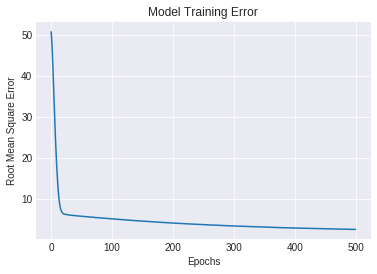

In [19]:

USE_SAVED_MODEL = False

if USE_SAVED_MODEL == False:
    history = model.fit(x_train,
                    y_train,
                    epochs = 500,
                    batch_size = 256,
                    validation_split = 0.2, #data = (x_test, y_test),
                    callbacks = callbacks
                    )
    plt.style.use('seaborn-darkgrid')
    plt.plot(history.history['rmse'])
    plt.xlabel('Epochs')
    plt.ylabel('Root Mean Square Error')
    plt.title('Model Training Error')
    plt.show() 
    
else:
    model.load_weights(model_dir+"base_model_weights_1.h5")
                    

In [21]:
lookid_dir = '../input/IdLookupTable.csv'
lookid_data = pd.read_csv(lookid_dir)
test_data = pd.read_csv(test_file)

x_test = []
for i in range(0,len(test_data)):
    img = test_data['Image'][i].split(' ')
    x_test.append(img)
    
x_test = np.array(x_test,dtype = 'float')
x_test = x_test/255.0
x_test = x_test.reshape(-1,96,96,1)    

y_test = model.predict(x_test)
y_test = np.clip(y_test,0,96)
np.save('../output/y_train_base', y_test)

lookid_list = list(lookid_data['FeatureName'])
imageID = list(lookid_data['ImageId']-1)
pred_list = list(y_test)

rowid = list(lookid_data['RowId'])

feature = []
for f in list(lookid_data['FeatureName']):
    feature.append(lookid_list.index(f))
    
    
submit_data = []
for x,y in zip(imageID,feature):
    submit_data.append(pred_list[x][y])
rowid = pd.Series(rowid,name = 'RowId')
loc = pd.Series(submit_data,name = 'Location')
submission = pd.concat([rowid,loc],axis = 1)
submission.to_csv('../output/w207_base_submission.csv',index = False)    

In [ ]:
if 0:
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()
    try:
        del model # this is from global space - change this as you need
    except:
        print("Model clear Failed")
    print(gc.collect())    